# Visualize and optimize

We start by importing the data from csv file. Numpy is our weapon of choice here, because we will use it heavily throughout. The data consists of four columns: Subject ID,actigraph hrs, self-report hrs, and a difference score. Our variables of interest are the actigraph hrs and self-report hrs. Both these variables measure time asleep in hours in 197 individuals. We can view a sample just to make sure it's all there:

In [2]:
import numpy as np
np.set_printoptions(precision=2, suppress=True) # display 2 d.p.
data = np.genfromtxt('data.csv', delimiter=',', skip_header=1)
print("We have {} rows in the data set. e.g.,:".format(data.shape[0]))
data[60:80,:].view()  # view the first 10 records

We have 197 rows in the data set. e.g.,:


array([[ 33751.  ,      7.69,      8.83,      1.14],
       [ 33791.  ,      6.97,      7.83,      0.86],
       [ 34241.  ,      8.56,      8.5 ,     -0.06],
       [ 34242.  ,      8.36,      9.92,      1.56],
       [ 34532.  ,      6.31,      6.33,      0.02],
       [ 35781.  ,      7.18,      8.33,      1.15],
       [ 35981.  ,      5.77,      4.75,     -1.02],
       [ 37451.  ,      7.13,      9.25,      2.13],
       [ 37452.  ,      6.29,      8.33,      2.04],
       [ 37571.  ,      6.22,       nan,     -1.72],
       [ 37572.  ,      5.15,       nan,     -1.65],
       [ 38101.  ,      9.43,     10.33,      0.9 ],
       [ 38262.  ,      6.55,      4.5 ,     -2.05],
       [ 38501.  ,      7.1 ,      6.25,     -0.85],
       [ 38512.  ,      6.98,      4.42,     -2.56],
       [ 39331.  ,      7.04,      7.  ,     -0.04],
       [ 39332.  ,      6.03,      6.67,      0.64],
       [ 40391.  ,      6.66,      4.67,     -1.99],
       [ 40392.  ,      6.1 ,      5.83,     -

Oh dear! We have missing data (nan)!. We will have to remove those rows.

In [3]:
data = data[~np.isnan(data).any(axis=1)]
print("No nans remaining. There are {} rows in the data set".format(data.shape[0]))

No nans remaining. There are 193 rows in the data set


Differences exist between our two variables of interest. To view these differences in more detail, we can use the magic of Seaborn (thanks Sam!). A simple scatterplot will show us the variables covary substantially (~25%)

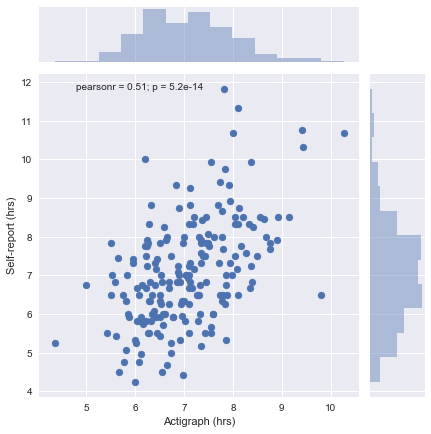

In [4]:
from scipy import stats, integrate
import matplotlib.pyplot as pl
import seaborn as ss
%matplotlib inline

x = data[:,1] # Actigraph hrs
y = data[:,2] # Self-report hrs
ss.set(color_codes=True)
ss.jointplot(x, y).set_axis_labels("Actigraph (hrs)", "Self-report (hrs)")
#ss.jointplot(x=d[:,0], y=d[:,1], kind="kde");

In [5]:
# Add a z-score transform
x_t = stats.zscore(x)
y_t = stats.zscore(y)
#ss.jointplot(x_t, y_t).set_axis_labels("Actigraph (hrs)", "Self-report (hrs)")
d = data[:,1:3]
d_t = np.asarray([x_t,y_t]).T
d_t.shape
#print(np.percentile(x_t,10))
#print(np.percentile(y_t,10))
#print(np.percentile(x_t,10) - np.percentile(y_t,10))
print(x.min(),x_t.min(),y.min(),y_t.min())
print(x.max(),x_t.max(),y.max(),y_t.max())

4.35 -2.9001287708 4.25 -2.06952796037
10.26 3.41340091683 11.83 3.46062937126


Our aim is to divide the data into tripartite divisions (on the basis of hours) which result in three equivalent (but not equal) proportions in both data sets. So we build a cost function to express the difference in proportions between the two datasets obtained with any set of division thresholds (params). We also include an option to set a minimum percentage in the top and bottom divisions (minpercent).

In [37]:
def split_cost(params, minpercent=10, array=d): # array = [actHrs, psqiHrs], params = [lo, hi]
    
    a = array[:,0] 
    b = array[:,1]
    lo, hi = params # threshold to test
    bottomPercenta = np.percentile(a, minpercent)
    bottomPercentb = np.percentile(b, minpercent)
    topPercenta = np.percentile(a, 100-minpercent)
    topPercentb = np.percentile(b, 100-minpercent)
    lb = max(bottomPercenta, bottomPercentb)
    ub = min(topPercenta, topPercentb)
    
    # Enforce restrictions to ensure some membership in each division
    if lo < lb:
        lo = lb
    if hi > ub:
        hi = ub
    #if lo < max(a.min(), b.min()):
    #    lo = max(a.min(), b.min())
    #if hi > min(a.max(), b.max()):
    #    hi = min(a.max(), b.max())
    
    loErr = abs(sum(a <= lo) - sum(b <= lo))
    hiErr = abs(sum(a >= hi) - sum(b >= hi))
    sumErr = loErr + hiErr
    return sumErr

params=[6,10]
print("The number differences in the two datasets with {} is: {}".format(params, split_cost(params)))

The number differences in the two datasets with [6, 10] is: 44


In [28]:
xx = np.linspace(4,13,num=120)
yy = np.linspace(4,13,num=120)

#results = pd.DataFrame(0, index = x, columns = y)
Z = np.empty([len(xx),len(yy)])
                    
for row,i in enumerate(xx):
    for col,j in enumerate(yy):
        Z[row,col] = split_cost(params=[i,j], minpercent=1, array=d)
        
Z.view()

array([[ 15.,  15.,  15., ...,  23.,  23.,  23.],
       [ 15.,  15.,  15., ...,  23.,  23.,  23.],
       [ 15.,  15.,  15., ...,  23.,  23.,  23.],
       ..., 
       [  0.,   0.,   0., ...,   8.,   8.,   8.],
       [  0.,   0.,   0., ...,   8.,   8.,   8.],
       [  0.,   0.,   0., ...,   8.,   8.,   8.]])

In [29]:
Z.shape

(120, 120)

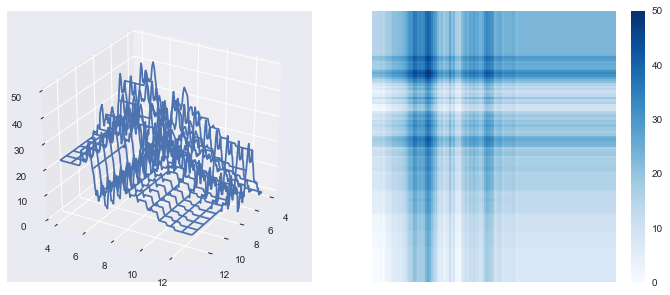

In [30]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.animation
%matplotlib inline

X = np.tile(xx,(120,1))
Y = np.tile(yy,(120,1))
Y = Y.T

fig = pl.figure(figsize=(12,5))
ax = fig.add_subplot(121, projection='3d')
ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
ax.view_init(30,30)

ax = fig.add_subplot(122)
ax = ss.heatmap(Z, cmap="Blues", xticklabels=False, yticklabels=False)
pl.show()

In [39]:
from scipy.optimize import optimize
result = np.asarray([0,0])
result = result.reshape(1,2)
lower = np.linspace(4, 13, num=100)
upper = np.linspace(4, 13, num=100)
for i in lower:
    for j in upper:
        minimum = optimize.fmin(split_cost, x0=([i,j]), disp=0)
        if split_cost(minimum) < 1:
            if minimum[0] < minimum[1]:
                result = np.append(result,minimum.reshape(1,2), axis = 0)

result
#minimum = optimize.fmin(split_cost,[6,8])

array([[ 0.  ,  0.  ],
       [ 7.  ,  7.12],
       [ 7.11,  7.12],
       [ 6.99,  7.  ],
       [ 6.99,  7.11],
       [ 6.99,  7.12],
       [ 6.99,  7.  ],
       [ 7.  ,  7.  ],
       [ 7.  ,  7.  ],
       [ 7.  ,  7.11],
       [ 6.99,  7.  ],
       [ 7.  ,  7.  ],
       [ 7.  ,  7.  ],
       [ 6.99,  7.  ],
       [ 7.11,  7.12],
       [ 7.11,  7.12]])

In [39]:
# solutions obtained with d_t:
#split_cost([-1.05, 0.41])
#split_cost([-1.04, 0.84]) 
#split_cost([-0.73, 0.42])

0

In [25]:
d

array([[  5.88,   5.92],
       [  5.53,   7.  ],
       [  6.32,   5.83],
       [  6.03,   5.83],
       [  6.4 ,   7.33],
       [  7.45,   6.83],
       [  6.57,   5.72],
       [  6.12,   4.97],
       [  6.96,   5.95],
       [  6.12,   5.92],
       [  7.59,   6.  ],
       [  8.11,  11.33],
       [  7.34,   7.83],
       [  7.43,   7.5 ],
       [  6.13,   6.75],
       [  5.5 ,   7.83],
       [  8.92,   8.5 ],
       [  7.49,   8.08],
       [  7.51,   7.75],
       [  7.39,   7.5 ],
       [  5.  ,   6.75],
       [  7.54,   5.67],
       [  7.17,   6.67],
       [  6.23,   6.67],
       [  6.25,   7.75],
       [  6.15,   5.75],
       [  6.29,   6.33],
       [  7.43,   5.5 ],
       [  7.45,   7.83],
       [  6.56,   6.  ],
       [  7.36,   8.42],
       [  7.78,   6.33],
       [  7.49,   7.83],
       [  7.97,   7.  ],
       [  7.45,   8.5 ],
       [  6.24,   7.92],
       [  6.63,   7.92],
       [  7.26,   6.5 ],
       [  7.28,   5.83],
       [  6.23,   5.83],
